In [ ]:
# импорт зависимостей

import pandas as pd
import numpy as np

In [ ]:
df_v = pd.read_csv(
    "./Data/qlook-data.txt", index_col=0, skiprows=4, header=None, names=["s", "v"]
)
df_v.index = df_v.index.map(pd.Timestamp)

In [ ]:
df_v.v = df_v.v.str.strip()
df_v.v = df_v.v.replace("N/A", 0)
df_v.v = df_v.v.astype(float)
df_v = df_v.dropna()
# df_v

In [ ]:
cr_time = 27 * 24 * 3600  # s
omega = 360 / cr_time  # º/s

In [ ]:
omega * 3600

In [ ]:
phi_step = 3600 * omega
phi_step

0.5555555555555556

In [ ]:
r0 = 20
rSolar = 700000  # in meters

In [ ]:
def v(t0):
    return df_v.loc[t0]["v"]


v(pd.Timestamp("2018-07-04 03:00:00"))

np.float64(348.96038)

In [ ]:
def r(t, t0):
    return r0 + v(t0) * (t - t0)

Создание мультииндекса: модель данных — трёхмерный массив с индексами [дата, ɸ, R]

In [ ]:
def make_index(A, B, phi_step=phi_step, R_start=20, R_stop=215, R_step=1):
    """
    A, B: date-like (e.g. '2025-09-01', pd.Timestamp)
    phi_step: step size in radians for phi (0 .. 2π inclusive)
    R_*: radius range and step (inclusive of R_stop if it lands exactly)
    """
    dates = pd.date_range(A, B, freq="1H")

    # Phi: 0 to 2π inclusive (avoid rounding misses at the endpoint)
    nudge = 1e-12
    phi = np.arange(0.0, 360, phi_step)

    # R: 20..215 inclusive in steps of 5 (default)
    R = np.arange(R_start, R_stop + nudge, R_step)

    mi = pd.MultiIndex.from_product([dates, phi, R], names=["date", "phi", "R"])
    return mi

In [ ]:
idx = make_index("2018-07-01 18:00:00.000", "2018-07-30 17:00:00.000")

df = pd.DataFrame(index=idx)
df["v"] = [[]] * len(df)

/var/folders/3z/b4fclst96kbd90mb019v618m0000gn/T/ipykernel_72024/2679524296.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(A, B, freq="1H")


In [ ]:
# ...existing code...
mask = (df.index.get_level_values("R") == 20) & (df.index.get_level_values("phi") == 0)
dates = df.index.get_level_values("date")[mask]

# for idx, d in zip(df.index[mask], dates):
#     df.at[idx, "v"] = [v(d)]

In [ ]:
mask = (df.index.get_level_values("R") > 20) & (df.index.get_level_values("phi") == 0)
dates = df.index.get_level_values("date")[mask]

In [ ]:
def r(v, t, t0, r0=20):
    return np.round((v * (t - t0).total_seconds() + r0 * rSolar) / rSolar)

In [ ]:
def propagate_speed(v, t0):
    arrR = []
    # t0 = pd.Timestamp("2018-07-01 18:00:00")
    arrT = range(0, 7 * 24, 1)
    for time in arrT:
        arrR.append(r(v, t0 + pd.Timedelta(hours=time), t0))
    arrTime = [pd.Timedelta(hours=time) + t0 for time in arrT]
    my_df = pd.DataFrame(arrR, index=arrTime, columns=["R"])
    return my_df

In [ ]:
propagate_speed(500, pd.Timestamp("2018-07-01 18:00:00"))

,R
2018-07-01 18:00:00,20.0
2018-07-01 19:00:00,23.0
2018-07-01 20:00:00,25.0
2018-07-01 21:00:00,28.0
2018-07-01 22:00:00,30.0
...,...
2018-07-08 13:00:00,439.0
2018-07-08 14:00:00,442.0
2018-07-08 15:00:00,444.0
2018-07-08 16:00:00,447.0


In [ ]:
df = pd.read_pickle("./Outputs/Propagated SW.pkl")

# for t0 in df_v.index:
#     v_i = df_v.loc[t0].v

#     # -----------------------------------------------------
#     # phi = 0 for a given SW speed @ sun
#     v_p_arr = propagate_speed(
#         v_i,
#         t0,
#     )

#     for t in v_p_arr.index:
#         if (v_p_arr.loc[t].R <= 215) and t in dates:
#             # print(df.loc[(t, 0.0, v1.loc[t].R)])
#             df.loc[(t, 0, v_p_arr.loc[t].R)]["v"] = df.loc[(t, 0, v_p_arr.loc[t].R)][
#                 "v"
#             ] + [v_i]

#     # -----------------------------------------------------
#     # phi > 0, t = t0 + delta_t
#     for phi in np.arange(0, 360, phi_step):
#         t = t0 + pd.Timedelta(seconds=phi / omega).round("1h")
#         v_p_arr = propagate_speed(
#             v_i,
#             t,
#         )

#         for t in v_p_arr.index:
#             if (v_p_arr.loc[t].R <= 215) and t in dates:
#                 # print(df.loc[(t, phi, v1.loc[t].R)])
#                 df.loc[(t, phi, v_p_arr.loc[t].R)]["v"] = df.loc[
#                     (t, phi, v_p_arr.loc[t].R)
#                 ]["v"] + [v_i]

/var/folders/3z/b4fclst96kbd90mb019v618m0000gn/T/ipykernel_72024/2747733263.py:14: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df.loc[(t, 0, v_p_arr.loc[t].R)]["v"] = df.loc[(t, 0, v_p_arr.loc[t].R)][
/var/folders/3z/b4fclst96kbd90mb019v61

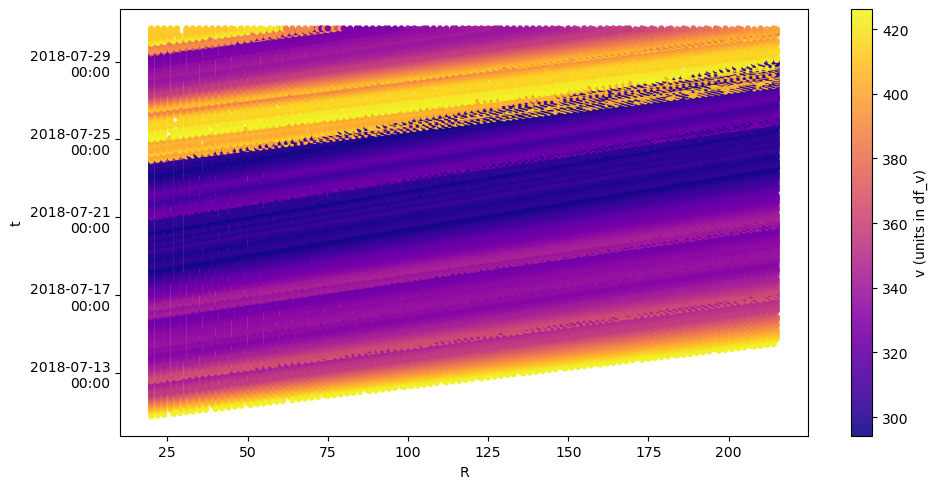

In [ ]:
# plot t vs R with v as color
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

tmp = df.xs(120.0, level="phi").reset_index()  # index -> columns: date, R, v
tmp["date"] = pd.to_datetime(tmp["date"])

# reduce v lists to a scalar (mean) and drop empties
tmp["v_scalar"] = tmp["v"].apply(
    lambda x: (
        np.nan
        if (not isinstance(x, (list, tuple, np.ndarray)) or len(x) == 0)
        else x[-1]
    )
)
plot_df = tmp.dropna(subset=["v_scalar"])

plt.figure(figsize=(10, 5))
sc = plt.scatter(
    plot_df["R"],
    plot_df["date"],
    c=plot_df["v_scalar"],
    cmap="plasma",
    s=12,
    alpha=0.9,
)
plt.colorbar(sc, label="v (units in df_v)")
plt.xlabel("R")
plt.ylabel("t")
ax = plt.gca()
ax.yaxis.set_major_locator(mdates.AutoDateLocator())
ax.yaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d\n%H:%M"))
plt.tight_layout()
plt.show()
# ...existing code...

In [ ]:
df_head = df.head(2000)

In [ ]:
# compute global v min/max across the whole dataframe (extract scalar from lists)
v_scalar_all = df["v"].apply(
    lambda x: np.nan
    if (not isinstance(x, (list, tuple, np.ndarray)) or len(x) == 0)
    else max(x)
)
vmin = 150
vmax = float(v_scalar_all.max())

In [ ]:
from ipywidgets import interact, widgets
import matplotlib.pyplot as plt
import numpy as np

# prepare date options (strings for the slider)
dates = sorted(df.index.get_level_values("date").unique())
date_strs = [d.strftime("%Y-%m-%d %H:%M:%S") for d in dates]

def plot_polar(date_str):
    d = pd.Timestamp(date_str)
    # select rows for the chosen date
    try:
        tmp = df.xs(d, level="date").reset_index()  # columns: phi, R, v
    except KeyError:
        print("No data for", date_str)
        return

    # convert stored v lists to a scalar (use last value here)
    tmp["v_scalar"] = tmp["v"].apply(
        lambda x: np.nan
        if (not isinstance(x, (list, tuple, np.ndarray)) or len(x) == 0)
        else max(x)
    )
    tmp = tmp.dropna(subset=["v_scalar"])
    if tmp.empty:
        print("No v values for", date_str)
        return

    phi_rad = np.deg2rad(tmp["phi"].astype(float))
    r = tmp["R"].astype(float)
    c = tmp["v_scalar"].astype(float)

    plt.figure(figsize=(6, 6))
    ax = plt.subplot(projection="polar")
    sc = ax.scatter(phi_rad, r, c=c, cmap="plasma", s=1, alpha=0.9, vmin=vmin, vmax=vmax)
    cb = plt.colorbar(sc, pad=0.1)
    cb.set_label("v")
    ax.set_title(f"phi-R (polar) at {date_str}")
    # optional: set r limits if desired
    ax.set_ylim(tmp["R"].min() - 1, tmp["R"].max() + 1)
    plt.show()

# interactive slider (use continuous_update=False for performance)
interact(
    plot_polar,
    date_str=widgets.SelectionSlider(
        options=date_strs, value=date_strs[0], description="date", continuous_update=False, layout=widgets.Layout(width="90%")
    ),
)


interactive(children=(SelectionSlider(continuous_update=False, description='date', layout=Layout(width='90%'),…

<function __main__.plot_polar(date_str)>

In [ ]:
215 * np.sin(np.deg2rad(3)) 

np.float64(11.252230592232925)

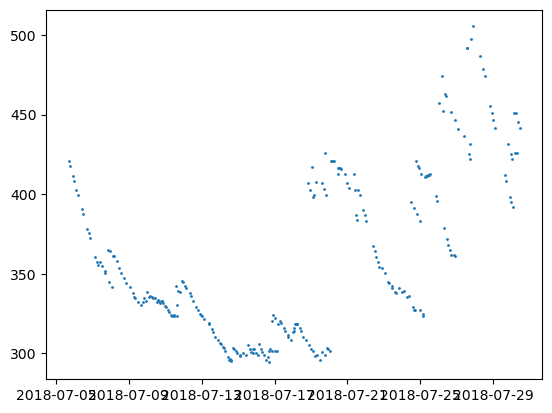

In [ ]:
ddf = df.xs(0.0, level="phi").xs(215, level="R")
ddf["v"] = ddf["v"].apply(lambda x: np.nan if len(x) == 0 else max(x))
ddf.dropna(inplace=True)
plt.scatter(ddf.index, ddf["v"], s=1)

In [ ]:
df.to_pickle("./Outputs/Propagated SW.pkl")